# Regression Analysis for Predicting Property Value of 2017 Houses in Zillow Dataset

## Goals of this Project:

1. Determine what features are indicative of house value
2. Use regression modeling to make an effective predictive model of the value of a house based on determined features
3. Based on the infomation gathered and sorted through, make reccommendations for future models

## Imports

In [1]:

import wrangle as w
import model as m

import os
import numpy as np
np.random.seed(198)
import pandas as pd
from scipy import stats
from pydataset import data
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings("ignore")

# 1. Acquire Data

## Function lives in my wrangle file, it will pull in new data if an os path does not already exist. An env file with username, password, and host name is required. 

### For the purposes of this project the features that were pulled from the database are bedroom and bathroom count, the square feet of the completed house, the year built, fips, sqare feet of the lot, and our target variable, tax value dollar count.

In [2]:
df = w.new_zillow_data()

In [3]:
df.head(3)

,bathroomcnt,bedroomcnt,taxvaluedollarcnt,calculatedfinishedsquarefeet,yearbuilt,fips,lotsizesquarefeet
0,3.5,4.0,1023282.0,3100.0,1998.0,6059.0,4506.0
1,1.0,2.0,464000.0,1465.0,1967.0,6111.0,12647.0
2,2.0,3.0,564778.0,1243.0,1962.0,6059.0,8432.0


# 2. Clean Data

## Calling cleaning function that also lives in my wrangle file. This function: 
- creates a column called "property age" that holds values for the age the property was in 2017
- renames columns to be more human readable
- replaces any white spaces with null values
- deletes all null values
- converts datatypes to integers (with the excpetion of 'fips')
- translates 'fips' to county and gives the counties human readable names
- gets dummies for counties to be modleable
- removes outliers based on human discretion 
- - houses will have no more than 5 bedrooms and/or 5 bathrooms
- - be between 1,000 and 7,000 square feet
- - have no more than 20,000 sqarefoot lot size
- - and be no more than 1.3 million dollars
- after making appropriate calculations, columns 'fips', and 'yearbuilt' are dropped
- finally, a dataframe is returned.

In [4]:
df=w.clean_data(df)

# 3. Split Data

In [5]:
#split data into three main dataframes
train, validate, test = w.split_data(df)

In [6]:
# secondary split to seperate the target feature
X_train, y_train, X_validate, y_validate,  X_test, y_test = w.X_y_split(df, 'property_value')


# 4. Feature Engineering


### After an inital evaluation I decided to engineer some new features before exploring. I calculated the ratio of bathrooms to bedrooms (bath/bed), and the ratio of house square footage to lot square footage.

In [7]:
#here we give all three dataframes all three of the generated features
train, validate, test = w.feature_generator(train, validate, test)

In [8]:
train.head(3)

,bath_rooms,bed_rooms,property_value,house_square_feet,property_square_feet,property_age,year_built,county,county_LA,county_Orange,county_Ventura,bath_to_house_sqft_ratio,house_to_lot_sqft_ratio,bath_to_bed_ratio
43855,2,4,365043.0,1382,6078,63,1954,LA,1,0,0,0.001447,0.227377,0.500000
28377,2,3,714291.0,2018,2840,19,1998,Orange,0,1,0,0.000991,0.710563,0.666667
5790,2,2,629951.0,1553,4501,82,1935,LA,1,0,0,0.001288,0.345034,1.000000


# 5. Exploration and Visualizations

## 1. Since we are trying to determine home value, what features correlate the most with our target?

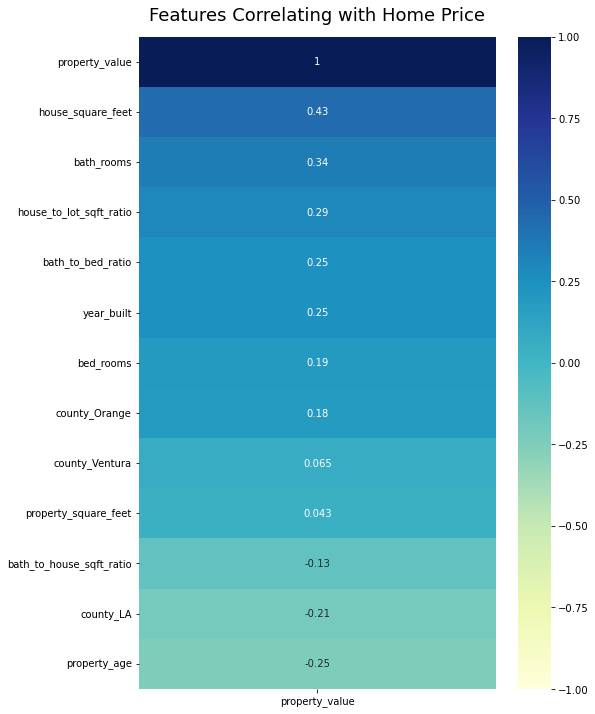

In [9]:
w.hvalue_corr_heatmap(train)

## 2. Following that same train of though, what features correlate most with the square footage of a house?

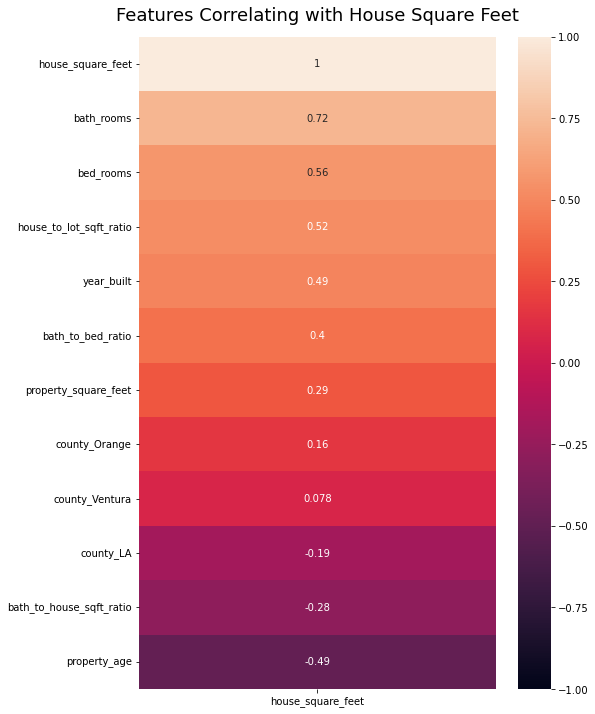

In [10]:
w.hsqft_corr_heatmap(train)

## At this point, I asked "what's up with the bathrooms?"


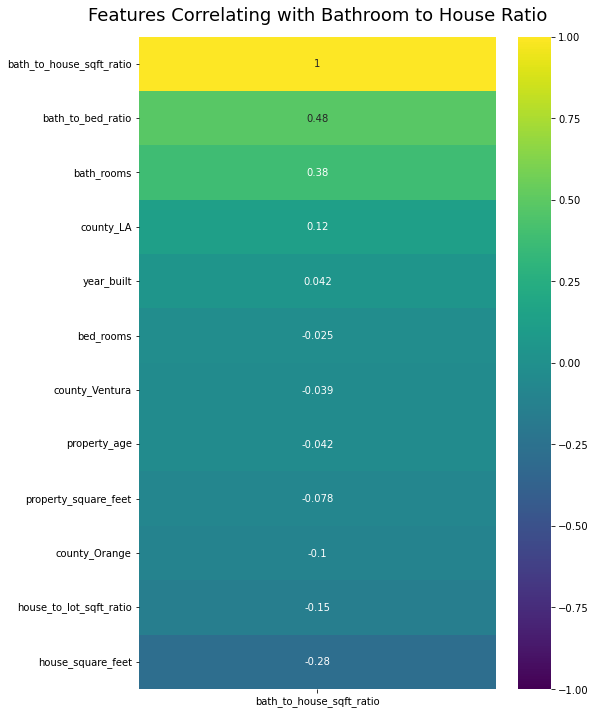

In [11]:
w.BTH_corr_heatmap(train)

## Is location something significant to consider when trying to predict value?

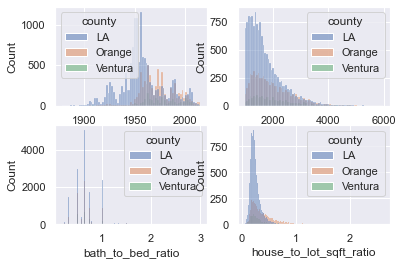

In [12]:
w.correlation_by_county(train)

## Exploration Summary

* From the target variable of property value we can see that house square footage has the highest correlation so it will be used in future modeling. 
* Based on the significance of bathrooms and the oddities in bath:house ratio, I will include those features as well. 
* Location could be significant in future models, but for now I will not use it as I do not want to parce through counties which would be necessary

# 5. Scaling


In [14]:
# adding engineered features to X before scaling
X_train, X_validate, X_test = w.X_feature_generator(X_train, X_validate, X_test)

In [16]:
#redefining X dataframes
X_train, X_validate, X_test=m.X_overwrite(X_train, X_validate, X_test)

In [18]:
X_train.head(3)

,bath_rooms,house_square_feet,bath_to_house_sqft_ratio,bath_to_bed_ratio
43855,2,1382,0.001447,0.500000
28377,2,2018,0.000991,0.666667
5790,2,1553,0.001288,1.000000


After running min-max and standard scales in a seperate notebook, I decided to use the standard scaler as the shape of the original and scaled data resemble each other more closely than those of the min-max scaler

In [19]:
X_train_scaled, X_validate_scaled, X_test_scaled = w.scale_data(X_train, X_validate, X_test)

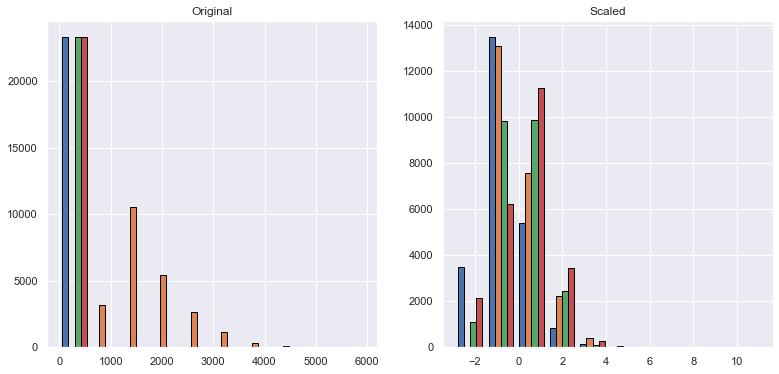

In [20]:
w.scaled_figure(X_train, X_train_scaled)

In [21]:
X_train_scaled.head(3)

,bath_rooms,house_square_feet,bath_to_house_sqft_ratio,bath_to_bed_ratio
43855,-0.233328,-0.668085,0.686947,-0.785908
28377,-0.233328,0.295523,-0.747467,0.005813
5790,-0.233328,-0.409001,0.185802,1.589254


# 6. Modeling

## Establishing a Baseline

* After comparing the mean and median on in sample and out of sample data, I decided to proceed with mean because the difference between the two is significantly lower

In [22]:
m.baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,273078.053937,272986.785485,91.268452
1,median_baseline,276570.488398,276442.318011,128.170387


## Model Comparisson

In [23]:
# this function runs four regressions models and returns a df of aggregated results
m.model_comparisson(X_train_scaled, y_train, X_validate_scaled, y_validate)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate
0,OLS Regressor,235846.685459,0.254091,237376.636656,0.243987
1,Lasso_alpha_1,235847.862994,0.254083,237364.243776,0.244066
2,GLM,237101.126145,0.246135,238977.096673,0.233743
3,Polynomial,235527.953061,0.256106,237235.626182,0.244883


### Based on this data, I decided to use the Polynomial model with degree 2 on my test set because it has the lowest RMSE on both train and validate

## Code for the Test

In [24]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)


In [25]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.property_value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.property_value, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.property_value, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  235527.95306133758 
Validation/Out-of-Sample:  237235.6261822522


In [26]:
y_test['value_pred_lm2'] = lm2.predict(X_test_degree2)

rmse_test = mean_squared_error(y_test.property_value, y_test.value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2 for Test sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2 for Test sample:  236811.84574209346


# Result of Model: 
### This model performed better than the baseline and had a result very close to the train and validate sets which means it is not overfit. 

# Conclusion:
* The features I used, square-feet, bathrooms, bath-to-house ratio, and bath-to-bed ratio all seem to be drivers of the value of a house. 

# Recommentation: 
* I recommend further analytical breakdown of the relationship between bathrooms and house value. Whether it is very large bathrooms, or many bathrooms, or both
* I believe further insights can be gained by analyzing the inverse relationship between 'yearbuilt' and 'property age', specifically in LA county
* I recommend more complete data

# Next Steps:
* I believe the first step is collecting more specific and complete data for future models to be built upon
* With this data as it is, next steps should be taking a deeper look into specific locations more accuate than fips.
* I believe human inferences can be made regarding house price based on the yearbuilt and the neighborhood and better models can be built using such features